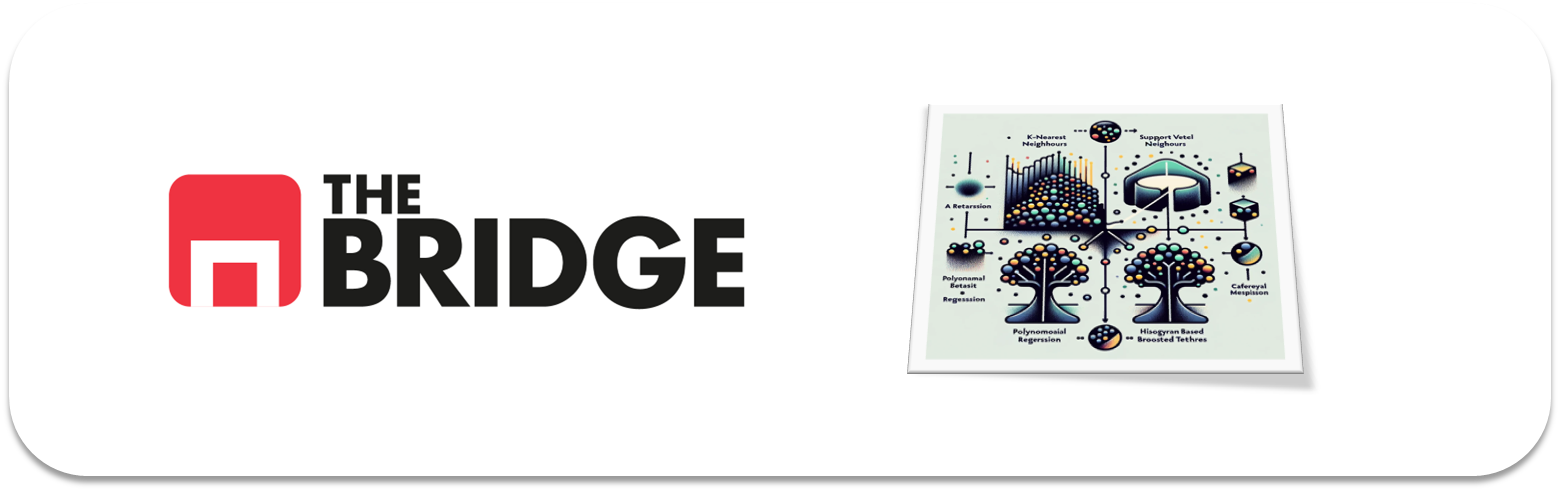

# Clasificacion

In [25]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import RAW_Toolbox as toolbox

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [26]:
df = pd.read_csv("./data/credit_npo.csv")

In [6]:
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [8]:
toolbox.describe_df(df)

,COL_N,DATA_TYPE,MISSINGS(%),UNIQUE_VALUES,CARDIN(%)
0,SeriousDlqin2yrs,int64,0.000000,2,0.015953
1,RevolvingUtilizationOfUnsecuredLines,float64,0.000000,10764,85.857861
2,age,int64,0.000000,78,0.622158
3,NumberOfTime30-59DaysPastDueNotWorse,int64,0.000000,10,0.079764
4,DebtRatio,float64,0.000000,11547,92.103374
5,MonthlyIncome,float64,5.750977,4167,33.237617
6,NumberOfOpenCreditLinesAndLoans,int64,0.000000,43,0.342985
7,NumberOfTimes90DaysLate,int64,0.000000,13,0.103693
8,NumberRealEstateLoansOrLines,int64,0.000000,16,0.127622
9,NumberOfTime60-89DaysPastDueNotWorse,int64,0.000000,8,0.063811


*observamos que hay nulos en MonthlyIncome y NumberOfDependants*

In [9]:
toolbox.tipifica_variables(df, 5, 20)

,nombre_variable,tipo_sugerido
0,SeriousDlqin2yrs,Binaria
1,RevolvingUtilizationOfUnsecuredLines,Numerica Continua
2,age,Numerica Discreta
3,NumberOfTime30-59DaysPastDueNotWorse,Numerica Discreta
4,DebtRatio,Numerica Continua
5,MonthlyIncome,Numerica Continua
6,NumberOfOpenCreditLinesAndLoans,Numerica Discreta
7,NumberOfTimes90DaysLate,Numerica Discreta
8,NumberRealEstateLoansOrLines,Numerica Discreta
9,NumberOfTime60-89DaysPastDueNotWorse,Numerica Discreta


In [28]:
# Nos cargamos duplicados
df.dropna(inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

El tipo de problema que estamos tratando es un problema de clasificación:   
- buscamos predecir a qué clase pertenecerá un individuo, en este caso, si va a encontrarse en dificultades financieras en los próximos dos años o no.  
La variable target en este caso es **"SeriousDlqin2yrs"**, que indica si una persona ha experimentado dificultades financieras graves en los últimos dos años. *

In [30]:
target = "SeriousDlqin2yrs"

### #1.3
Pinta la distribución de frecuencias del target y coméntala

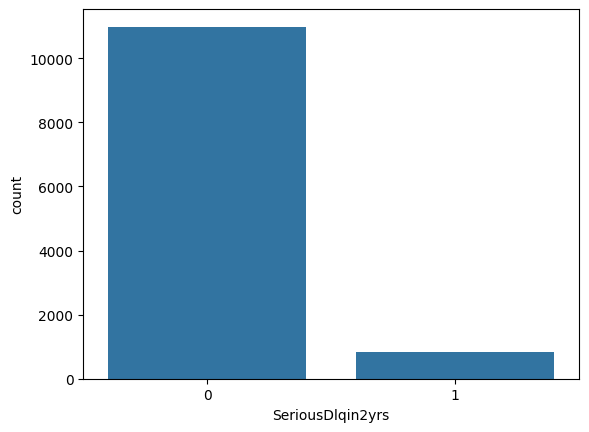

In [31]:
sns.countplot(data=df, x='SeriousDlqin2yrs');


*El dataset esta desbalanceado hacia los individuos que no han experimentado dificultades financieras graves en los últimos dos años. Notaremos su impacto al probar por ejemplo el hiperparámetro class_weight o el correspondiente al modelo seleccionado. Nos lo apuntamos porque aquí queremos ser muy precisos con la minoritaria (1)*

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [32]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

In [33]:
np.abs(df.corr()['SeriousDlqin2yrs']).sort_values(ascending=False)

SeriousDlqin2yrs                        1.000000
RevolvingUtilizationOfUnsecuredLines    0.280350
NumberOfTimes90DaysLate                 0.132191
NumberOfTime30-59DaysPastDueNotWorse    0.131163
age                                     0.106076
NumberOfTime60-89DaysPastDueNotWorse    0.101231
NumberOfDependents                      0.043825
NumberOfOpenCreditLinesAndLoans         0.029574
MonthlyIncome                           0.022199
DebtRatio                               0.001666
NumberRealEstateLoansOrLines            0.001321
Name: SeriousDlqin2yrs, dtype: float64

# Funcion n°2
## get_features_num_classification

In [44]:
def get_features_num_classification(dataframe, target_col, pvalue=0.05):
    """
    Devuelve una lista con las columnas numéricas del dataframe cuyo ANOVA con la columna designada por "target_col"
    supere el test de hipótesis con significación mayor o igual a 1-pvalue.

    Argumentos:
    dataframe (pd.DataFrame): DataFrame que contiene los datos.
    target_col (str): Nombre de la columna que debería ser el target de un modelo de clasificación.
    pvalue (float): Valor de significación para el test de hipótesis. Por defecto es 0.05.

    Returns:
    list: Lista de columnas numéricas cuyo ANOVA supera el test de hipótesis.
    """
    
    # Comprobación de que el dataframe no esté vacío
    if dataframe.empty:
        print("Error: El dataframe está vacío.")
        return None
    
    # Comprobación de que el target_col exista en el dataframe
    if target_col not in dataframe.columns:
        print(f"Error: La columna {target_col} no existe en el dataframe.")
        return None
    
     # Comprobar si 'target_col' es una variable categórica o discreta con baja cardinalidad
     # se utiliza pd.api.types.is_numeric_dtype() para verificar si una columna es de tipo numérico en el df
    if not pd.api.types.is_integer_dtype(dataframe[target_col]) and dataframe[target_col].nunique() > 10:
        print(f"Error: '{target_col}' must be a categorical or discrete column with low cardinality.")
        return None
    
    # Filtrar columnas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns
    
    # Comprobación de que hay al menos una columna numérica
    if not numeric_columns.any():
        print("Error: No hay columnas numéricas en el dataframe.")
        return None
    
    # Comprobación de que el pvalue sea un float válido entre 0 y 1
    if not isinstance(pvalue, float) or pvalue < 0 or pvalue > 1:
        print("Error: El valor de pvalue debe ser un float válido entre 0 y 1.")
        return None
    
    # Comprobación de que el dataframe tenga al menos dos categorías en target_col
    if len(dataframe[target_col].unique()) < 2:
        print(f"Error: La columna {target_col} tiene menos de dos categorías únicas.")
        return None
    
    # Realizar ANOVA para cada columna numérica
    selected_features = []
     
    for col in dataframe.select_dtypes(include=['number']):
        # Realizar el test ANOVA entre la columna actual y 'target_col'
        p_val = f_oneway(dataframe[col], dataframe[target_col])[1]
        # Comprobar si el p-value es menor o igual al umbral especificado
        if p_val <= pvalue:
            # Agregar la columna a la lista de features significativas
            selected_features.append(col)
    
    return selected_features

In [45]:
from scipy.stats import f_oneway

# Aplicar la función
target_col = target
selected_features = get_features_num_classification(df, target_col, pvalue=0.05)

# Mostrar las características numéricas significativas encontradas
print("Selected numerical features:")
print(selected_features)

Selected numerical features:
['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


# Funcion n°3
### plot_features_num_classification

In [48]:
def plot_features_num_classification(dataframe, target_col="", columns=[], pvalue=0.05):
    """
    Genera un pairplot del dataframe considerando la columna designada por "target_col" y aquellas incluidas en "columns"
    que cumplan el test de ANOVA para el nivel 1-pvalue de significación estadística.

    Argumentos:
    dataframe (pd.DataFrame): DataFrame que contiene los datos.
    target_col (str): Nombre de la columna que se usará como variable categórica en el pairplot. Por defecto es "".
    columns (list): Lista de columnas numéricas a considerar para el pairplot. Por defecto es la lista vacía.
    pvalue (float): Valor de significación para el test de ANOVA. Por defecto es 0.05.

    Returns:
    list: Lista de columnas numéricas que cumplen con las condiciones de ANOVA.
    """

    # Comprobación de que el dataframe no esté vacío
    if dataframe.empty:
        print("Error: El dataframe está vacío.")
        return None

    # Comprobación de que target_col exista en el dataframe
    if target_col not in dataframe.columns:
        print(f"Error: La columna {target_col} no existe en el dataframe.")
        return None

    # Comprobación de que target_col sea categórica,
    
    if not pd.api.types.is_integer_dtype(dataframe[target_col]):
        print(f"Error: La columna {target_col} no es categórica.")
        return None

    # Filtrar columnas numéricas si columns está vacía
    if not columns:
        columns = dataframe.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Comprobación de que hay al menos una columna numérica
    if not columns:
        print("Error: No hay columnas numéricas en el dataframe.")
        return None

    # Comprobación de que el pvalue sea un float válido entre 0 y 1
    if not isinstance(pvalue, float) or pvalue < 0 or pvalue > 1:
        print("Error: El valor de pvalue debe ser un float válido entre 0 y 1.")
        return None

    # Comprobación de que el dataframe tenga al menos dos categorías en target_col
    if len(dataframe[target_col].unique()) < 2:
        print(f"Error: La columna {target_col} tiene menos de dos categorías únicas.")
        return None

    # Seleccionar solo las columnas que cumplen el test de ANOVA
    selected_columns = []
    for col in dataframe.select_dtypes(include=['number']):
        # Realizar el test ANOVA entre la columna actual y 'target_col'
        p_val = f_oneway(dataframe[col], dataframe[target_col])[1]
        # Comprobar si el p-value es menor o igual al umbral especificado
        if p_val <= pvalue:
            # Agregar la columna a la lista de features significativas
            selected_columns.append(col)

    # Comprobación de que hay al menos una columna seleccionada
    if not selected_features:
        print("Error: No hay columnas que cumplan con las condiciones de ANOVA.")
        return None

    # Dividir el pairplot si el número de valores únicos en target_col es mayor que 5
    if len(dataframe[target_col].unique()) > 5:
        unique_targets = dataframe[target_col].unique()
        for i in range(0, len(unique_targets), 5):
            plot_data = dataframe[dataframe[target_col].isin(unique_targets[i:i+5])]
            plot = sns.pairplot(plot_data, hue=target_col, vars=[target_col] + selected_columns)
            plt.show()
    else:
        # Comprobar si hay que dividir el pairplot si el número de columnas seleccionadas es grande
        if len(selected_columns) > 5:
            # Dividir las columnas en grupos de máximo 5
            column_combinations = [selected_columns[i:i+4] for i in range(0, len(selected_columns), 4)]
            for cols in column_combinations:
                plot = sns.pairplot(dataframe, hue=target_col, vars=[target_col] + cols)
                plt.show()
        else:
            # Generar pairplot
            plot = sns.pairplot(dataframe, hue=target_col, vars=[target_col] + selected_columns)
            plt.show()

    return selected_columns

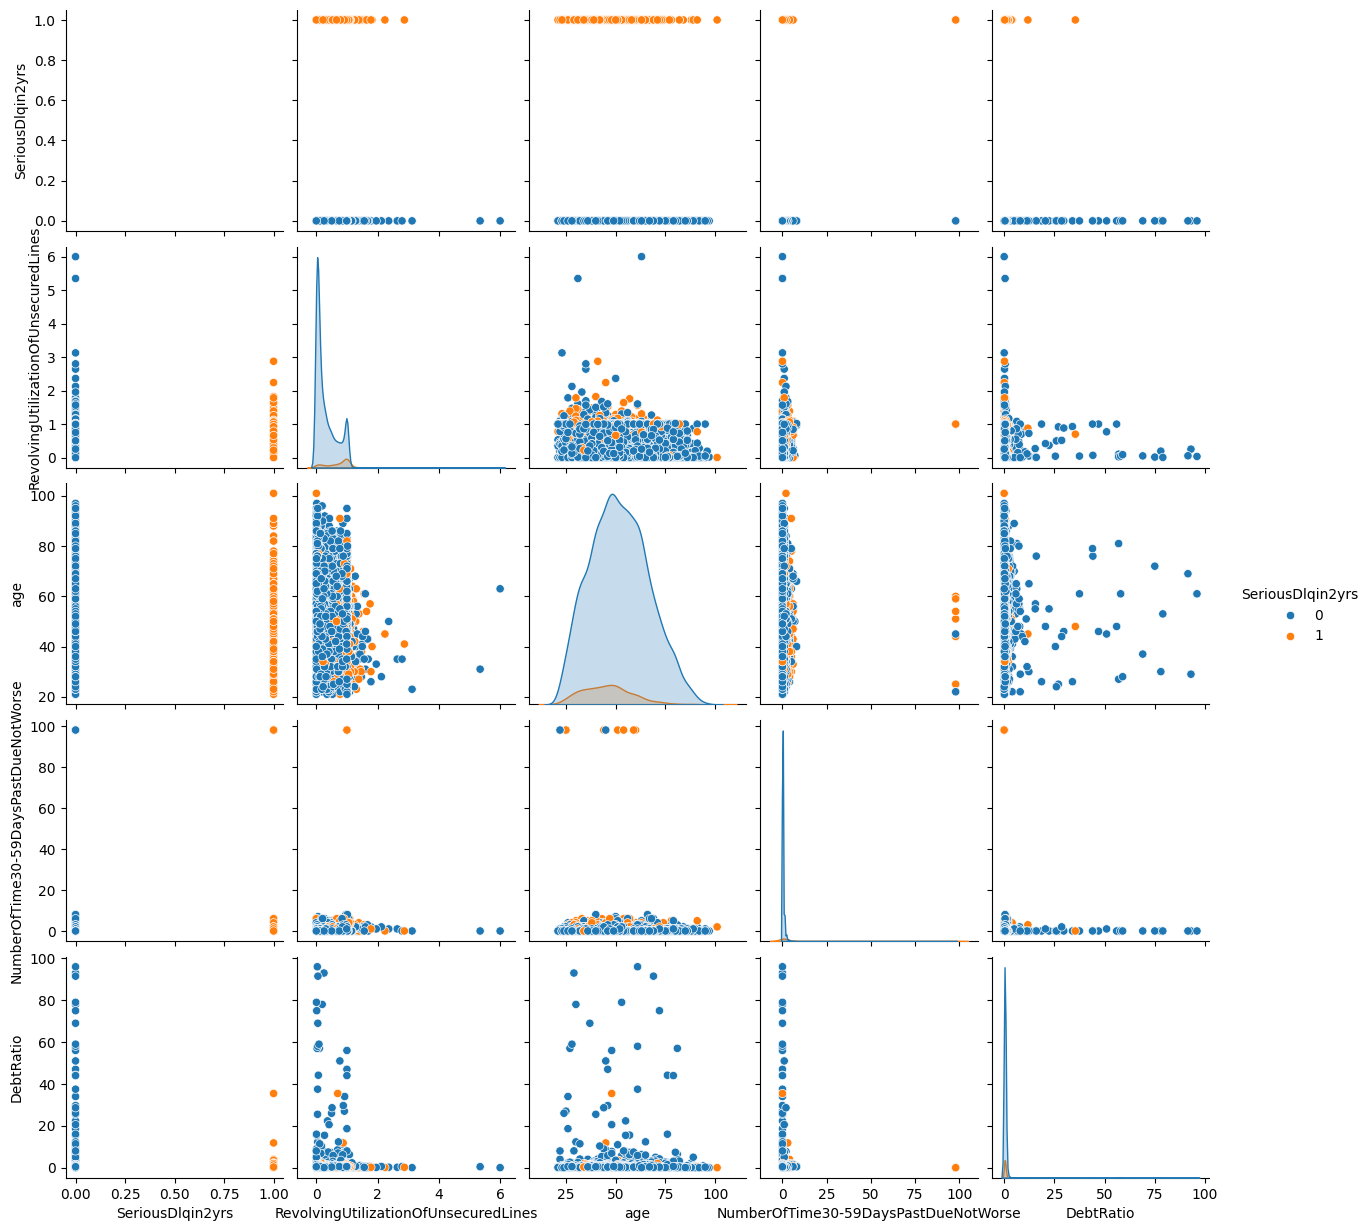

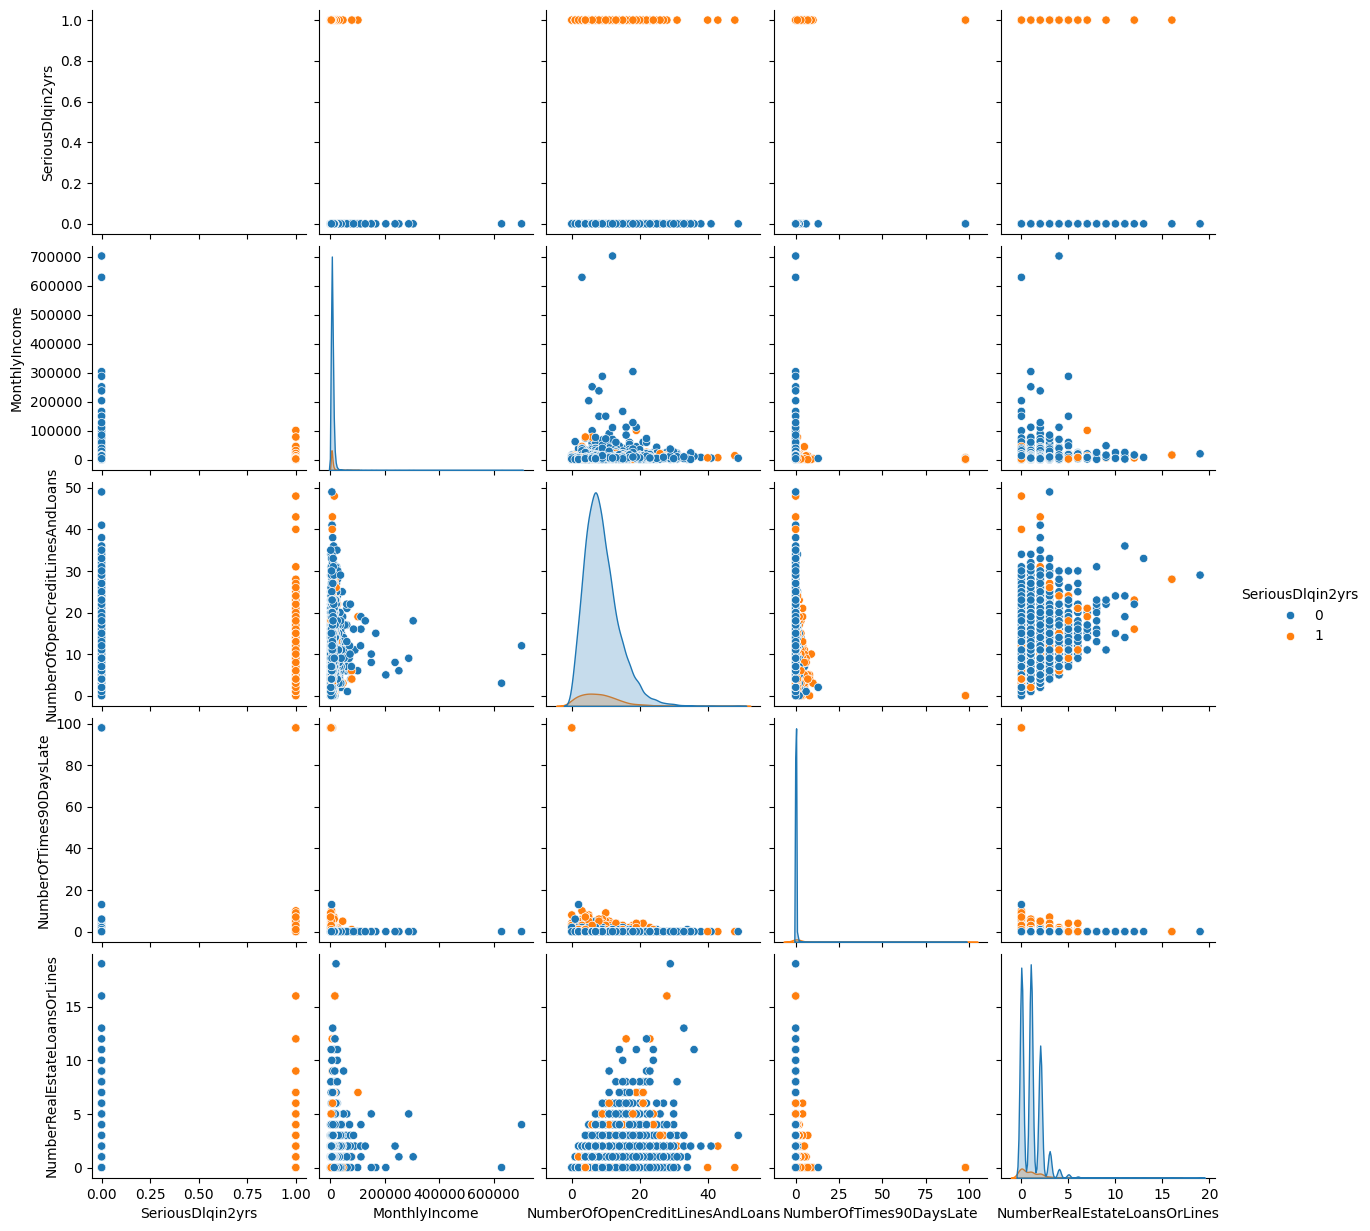

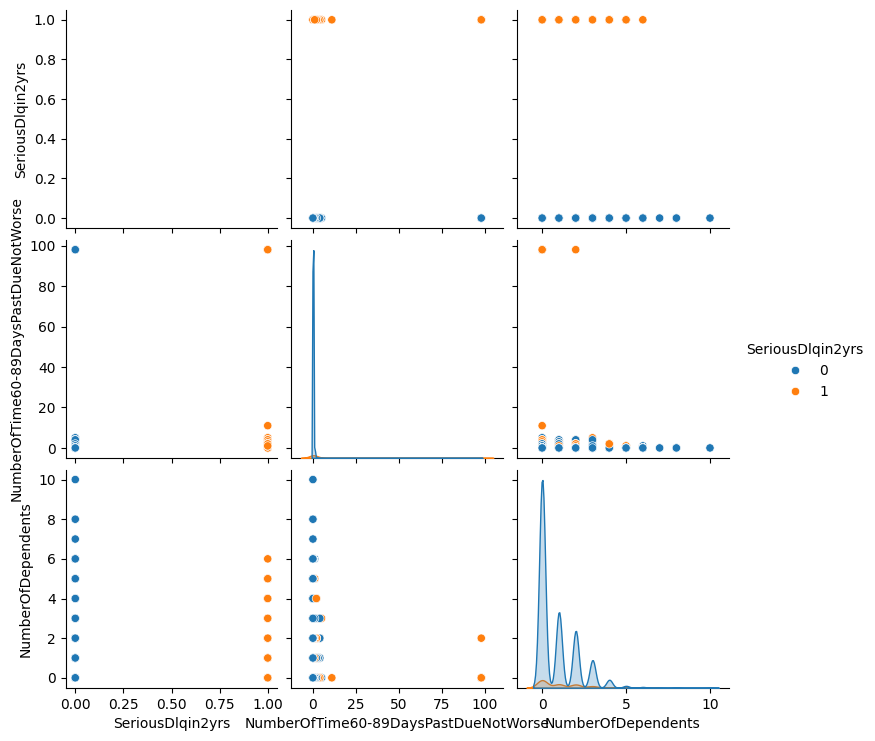

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [49]:
# Aplicar la función sin especificar columnas
plot_features_num_classification(df, target_col=target, pvalue=0.05)